# Functions

In [1]:
## Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize, BoundaryNorm
plt.rcParams.update({'font.size': 14})
import random
import math
from tqdm import tqdm
import time

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms


from google.colab import drive
drive.mount('/content/gdrive')
data_PATH = "gdrive/MyDrive/Transformer_to_Potts/"

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cos = nn.CosineSimilarity(dim=-1)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Mounted at /content/gdrive
Device: cuda:0


In [2]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, name, print=True, best_valid_loss=-float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.print = print
        self.name = name

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, time
    ):
        if current_valid_loss > self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            if self.print==True:
                print("Saving best model for epoch: %d, current val loss: %.4e, t: %.1f\n" % (epoch+1, current_valid_loss, time))
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                "time": time,
                }, self.name)

def loss_single_i(output):                        #out.shape = [B]
    g_i_b = output
    loss = g_i_b.mean()
    return loss

In [3]:
def l_i_o(list_indexes, patch_size):
    B_ = list_indexes.shape[0]
    N_dist_ = list_indexes.shape[1]
    num_patches_per_image = list_indexes.max().item() + 1  # Assuming the maximum index in list_indexes represents the number of patches

    # Calculate the dimensions of the original image
    patches_per_row = int((num_patches_per_image) ** 0.5)
    image_size = patches_per_row * patch_size

    list_indexes_original = torch.zeros(B_, N_dist_ * patch_size**2).type(torch.LongTensor)

    for b in range(B_):
        for n in range(N_dist_):
            patch_index = list_indexes[b, n].item()
            row = patch_index // patches_per_row
            col = patch_index % patches_per_row

            for i in range(patch_size):
                for j in range(patch_size):
                    pixel_index = (row * patch_size + i) * image_size + (col * patch_size + j)
                    list_indexes_original[b, n * patch_size**2 + i * patch_size + j] = pixel_index

    return list_indexes_original

def select_elements(original_data, list_indexes_original):
    B_, N = original_data.shape
    selected_elements = torch.zeros_like(list_indexes_original, dtype=original_data.dtype)

    for b in range(B_):
        selected_elements[b] = original_data[b].gather(0, list_indexes_original[b])

    return selected_elements

def l_i_o_linear(list_indexes, patch_size):
    B_ = list_indexes.shape[0]
    N_dist_ = list_indexes.shape[1]
    num_patches_per_image = list_indexes.max().item() + 1  # Assuming the maximum index in list_indexes represents the number of patches

    # Calculate the dimensions of the original image
    patches_per_row = int((num_patches_per_image) ** 0.5)
    image_size = patches_per_row * patch_size

    list_indexes_original = torch.zeros(B_, N_dist_ * patch_size**2).type(torch.LongTensor)

    for b in range(B_):
        for n in range(N_dist_):
            patch_index = list_indexes[b, n].item()
            row = patch_index // patches_per_row
            col = patch_index % patches_per_row

            for i in range(patch_size):
                for j in range(patch_size):
                    pixel_index = (row * patch_size + i) * image_size + (col * patch_size + j)
                    list_indexes_original[b, n * patch_size**2 + i * patch_size + j] = pixel_index

    return list_indexes_original.unsqueeze(-1)

def select_elements_linear(original_data, list_indexes_original):
    B_, N, _ = original_data.shape
    selected_elements = torch.zeros_like(list_indexes_original, dtype=original_data.dtype)

    for b in range(B_):
        selected_elements[b] = original_data[b].gather(0, list_indexes_original[b])

    return selected_elements


## Embedding

In [4]:
def image_at_distance_mask_patch(test_tensor_copy, distance):
    num_mask = int(distance*test_tensor_copy.shape[1])
    mask = torch.zeros(test_tensor_copy.shape[-1])
    if(num_mask>0):
        list_indexes = torch.zeros((test_tensor_copy.shape[0],num_mask))
    else:
        list_indexes = torch.zeros((test_tensor_copy.shape[0],1))
    for batch in range(test_tensor_copy.shape[0]):              #for every batch
        random_list = np.random.choice(range(test_tensor_copy.shape[1]), num_mask, replace=False)
        list_indexes[batch,:] = torch.tensor(random_list)
        for i,rand_index in enumerate(random_list):            #0
            test_tensor_copy[batch,rand_index] = mask
    return test_tensor_copy, list_indexes


def image_at_distance_mask_patch_big(inp_data_patch, big_patch):
    L = int(np.sqrt(inp_data_patch.shape[1]))
    rand_i = torch.randint(0,L-big_patch+1, (inp_data_patch.shape[0],2))
    mask = torch.zeros(inp_data_patch.shape[-1])
    list_indexes = torch.zeros((inp_data_patch.shape[0],big_patch**2))
    for batch in range(inp_data_patch.shape[0]):
        rand_x = rand_i[batch,0]
        rand_y = rand_i[batch,1]
        for dx in range(big_patch):
            for dy in range(big_patch):
                list_indexes[batch,dy+big_patch*dx] = (rand_x+dx)*L+rand_y+dy
                inp_data_patch[batch,(rand_x+dx)*L+rand_y+dy] = mask
    return inp_data_patch, list_indexes

def img_to_patch_spherical(x, patch_size):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, N, C, 2]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, N, C, _ = x.shape
    L = int(np.sqrt(N))
    x = x.reshape(B, L, L, C, 2)
    x = x.reshape(B, L//patch_size, patch_size, L//patch_size, patch_size, C, 2)
    x = x.permute(0, 1, 3, 2, 4, 5, 6) # [B, H', W', patch_H, patch_W, C, 2]
    x = x.flatten(1,2)
    x = x.flatten(2,5)          # [B, H'*W', C*p_H*p_W*2]
    return x

def patch_to_img_spherical(x, patch_size):
    B, N_temp, embed_d = x.shape
    C = int(embed_d/(2*patch_size*patch_size))
    x = torch.unflatten(x, 2, (patch_size, patch_size, C, 2))
    x = x.reshape(B, int(np.sqrt(N_temp)), int(np.sqrt(N_temp)), patch_size, patch_size, C, 2)
    x = x.permute(0,1,3,2,4,5,6)
    x = x.reshape(B,N_temp*patch_size*patch_size,C,2)
    return x



In [5]:
def encode_spherical_spin(rgb_image):    #tens=[d,n,n]
    # Convert RGB image to tensor if not already
    if not isinstance(rgb_image, torch.Tensor):
        tens = torch.tensor(rgb_image)
    else:
        tens = rgb_image

    if(tens.dim()==3):     #RGB
        tens = tens.permute(1,2,0)
    elif(tens.dim()==2):   #grey  [n,n]
        tens = tens.unsqueeze(2)

    tens = torch.clamp(tens.view(-1,tens.shape[-1]),0,1)    #[N,d]
    spherical_tens = torch.zeros(tens.shape[0], tens.shape[1], 2)

    spherical_tens[:,:,0] = tens
    spherical_tens[:,:,1] = 1-tens
    spherical_tens = spherical_tens/(torch.linalg.norm(spherical_tens, dim=2).unsqueeze(2))
    return spherical_tens

def encode_batch_spherical_spin(tens,N):    #tens=[b,d,n,n]
    RGB = False
    if(len(tens.shape)==4):     #RGB
        tens = tens.permute(0,2,3,1)
        RGB=True
    elif(len(tens.shape)==3):   #grey  [b,n,n]
        tens = tens.unsqueeze(3)
        RGB = False

    tens = torch.clamp(tens.view(tens.shape[0],N,-1),0,1).clone()    #[b,N,d]
    spherical_tens = torch.zeros(tens.shape[0], tens.shape[1], tens.shape[2], 2)

    if RGB==True:
        spherical_tens[:,:,0,0] = tens[:,:,0]
        spherical_tens[:,:,0,1] = 1-tens[:,:,0]
        spherical_tens[:,:,1,0] = tens[:,:,1]
        spherical_tens[:,:,1,1] = 1-tens[:,:,1]
        spherical_tens[:,:,2,0] = tens[:,:,2]
        spherical_tens[:,:,2,1] = 1-tens[:,:,2]

        #################
        spherical_tens = spherical_tens/(torch.linalg.norm(spherical_tens, dim=3).unsqueeze(3))
        #spherical_tens = spherical_tens.view(-1,N,6)/(torch.linalg.norm(spherical_tens.view(-1,N,6), dim=2).unsqueeze(-1))
        #spherical_tens = spherical_tens.view(-1,N,3,2)
    else:
        spherical_tens[:,:,:,0] = tens
        spherical_tens[:,:,:,1] = 1-tens
        spherical_tens = spherical_tens/(torch.linalg.norm(spherical_tens, dim=3).unsqueeze(3)) #[B,N,1,2]
    return spherical_tens

def decode_batch_spherical_spin(spherical_tens):    #spherical_tens=[b,N,d,2]
    tens = torch.zeros(spherical_tens.shape[0], spherical_tens.shape[1], spherical_tens.shape[2])
    for c in range(spherical_tens.shape[2]):
        tens[:,:,c] = (spherical_tens[:,:,c,0]/(spherical_tens[:,:,c,0]+spherical_tens[:,:,c,1]))
    tens = torch.nan_to_num(tens, nan=0, posinf=0, neginf=0)
    return tens

def generate_orthonormal_matrix(d, a):
    # Check if d is greater than a
    if d < a:
        raise ValueError("d must be greater than or equal to a")

    # Generate a random matrix of shape [d, a]
    matrix = torch.randn(d, a)

    # Orthogonalize the columns using the Gram-Schmidt process
    q, _ = torch.linalg.qr(matrix)

    return q

## Test

In [6]:
def q_repeating_spherical_patch_embed_de_embed_original(model, inp_data, patch_size, q_max, q_instants, normalized_sphere, d=0, mask_type=None, d_successive=0, g=0, l=1, boundary="fixed", layer_norm=False, big_patch=None, l_increase=None, clamp=None):            #data [batch, L, C]
    inp_data_patch = inp_data.clone()
    inp_data_spherical_original = patch_to_img_spherical(inp_data, patch_size)
    original_data = decode_batch_spherical_spin(inp_data_spherical_original).squeeze()

    if original_data.shape[-1]==3:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1],original_data.shape[2]))
        RGB = True
    else:
        tensor_images = torch.zeros((len(q_instants)+2,original_data.shape[0],original_data.shape[1]))
        RGB = False

    B_ = inp_data.shape[0]
    N_ = inp_data.shape[1]
    overlap_curves = torch.zeros((q_max, inp_data.shape[0], 7))

    if big_patch==None:
        if(d>0):
            original_data_noisy_patch, list_indexes = image_at_distance_mask_patch(inp_data_patch.clone(), d)    #list_indexes[b,int(d*N_)]
        else:
            list_indexes = torch.empty((1))
            original_data_noisy_patch = inp_data_patch.clone()
    else:
        original_data_noisy_patch, list_indexes = image_at_distance_mask_patch_big(inp_data_patch.clone(), big_patch)

    original_data_noisy = decode_batch_spherical_spin(patch_to_img_spherical(original_data_noisy_patch.clone(),patch_size)).squeeze()
    i=0
    tensor_images[i] = original_data
    i+=1
    tensor_images[i] = original_data_noisy

    list_indexes = list_indexes.type(torch.LongTensor)
    list_indexes_original = l_i_o(list_indexes, patch_size)

    for b in range(B_):
        tensor_images[i, b, list_indexes_original[b]] = -2

    inp_data_spherical = original_data_noisy_patch.clone()   #[B,N',p*p*c*2]
    #inp_data_spherical_noisy = patch_to_img_spherical(inp_data_spherical,patch_size).squeeze()
    inp_data_spherical = inp_data_spherical.to(device)
    data_spherical = inp_data_spherical.clone()
    ##############
    inp_data_spherical = inp_data_spherical.squeeze()
    data_spherical = data_spherical.squeeze()
    if d>0:
        mask = torch.ones(B_, N_).to(device)    #mask=[B,N]
        mask.scatter_(1, list_indexes.type(torch.LongTensor).to(device), 0)    #zeros in indexes
    else:
        mask = None

    label = select_elements(original_data.cpu(), list_indexes_original)
    overlap_spins = torch.zeros((q_instants.shape[0], B_, label.shape[1]))
    # Create mask for elements not selected
    mask_data = torch.ones(B_, N, dtype=torch.bool)
    mask_data.scatter_(1, list_indexes_original, False).to(device)
    # Extract other elements using the mask
    others = original_data[mask_data]#.view(B_, N - int(N*d)).to(device)

    ################## embed
    data_spherical= model.embed(data_spherical, mask=mask, layer_norm=layer_norm)
    inp_data_patch_original = model.embed(inp_data_patch, mask=mask, layer_norm=layer_norm)
    ##################
    for q in tqdm(range(q_max)):
        if l_increase is not None:
            l*=l_increase
        if mask_type==None:
            data_spherical = model.parallel_step(data_spherical, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
        elif mask_type=="first_step":                         #only first step
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=mask, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
            else:
                data_spherical = model.parallel_step(data_spherical, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
            #data = torch.clamp(data, -1, +1)
        elif mask_type=="random":
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=mask, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
            else:
                num_to_mask = d_successive[q-1]
                mask = create_random_mask(B_, N_, num_to_mask).to(device)
                data_spherical = model.parallel_step(data_spherical, mask=mask, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
        elif mask_type == "autoregressive":
            num_mask = list_indexes.shape[1]
            if q==0:
                data_spherical = model.parallel_step(data_spherical, mask=mask, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
            else:
                data_spherical = model.parallel_step(data_spherical, g=g, l=l, layer_norm=layer_norm, clamp=clamp)
            indexes_1d = torch.arange(B_).unsqueeze(1).expand(B_,num_mask).reshape(B_*num_mask).type(torch.LongTensor)
            inp_data_spherical[indexes_1d, list_indexes.reshape(B_*num_mask).type(torch.LongTensor)] = data_spherical[indexes_1d, list_indexes.reshape(B_*num_mask).type(torch.LongTensor)].clone()
            data_spherical = inp_data_spherical.clone()

        if normalized_sphere==True:
            data_spherical = data_spherical/(torch.linalg.norm(data_spherical, dim=-1).squeeze().mean(-1).unsqueeze(-1).unsqueeze(-1)+1e-9)
            #data_spherical = F.normalize(data_spherical, dim=-1)

        ################## de-embed
        data_spherical_TRUE = patch_to_img_spherical(model.de_embed(data_spherical,layer_norm=layer_norm),patch_size)
        ##################
        #data_spherical_TRUE = patch_to_img_spherical(data_spherical.clone(),patch_size)
        #data_spherical_TRUE = data_spherical_TRUE/(torch.linalg.norm(data_spherical_TRUE, dim=-1).unsqueeze(-1)+1e-6)
        data_spherical_TRUE_img = data_spherical_TRUE.clone()
        data = decode_batch_spherical_spin(data_spherical_TRUE.clone()).squeeze()
        data_norm = patch_to_img_spherical(data_spherical, patch_size).clone()
        data_norm = torch.linalg.norm(data_spherical, dim=-1).squeeze().mean(-1)
        if RGB == False:
            overlap_curves[q,:,0] = q
            overlap_curves[q,:,1] = 1-((original_data.squeeze()- data.squeeze())**2).mean(-1)
            label_pred = select_elements(data.squeeze().cpu(), list_indexes_original)
            overlap_curves[q,:,2] = 1-((label.squeeze()-label_pred.squeeze())**2).mean(-1)
            others_pred = data.squeeze().cpu()[mask_data]#.view(B_, N_ - int(N_*d),model.d).to(device)
            overlap_curves[q,:,3] = 1-((others.squeeze()- others_pred.squeeze())**2).mean(-1)
            #overlap_curves[q,:,2] = overlap_cosine_grey(inp_data_spherical_noisy, data_spherical_TRUE_img.squeeze())
            overlap_curves[q,:,4] = data_norm.mean(-1)
            overlap_curves[q,:,5] = torch.linalg.norm(label_pred, dim=-1).squeeze().mean(-1)
            overlap_curves[q,:,6] = torch.linalg.norm(others_pred, dim=-1).squeeze().mean(-1)

        else:
            overlap_curves[q,:,0] = q
            overlap_curves[q,:,1] = overlap_CIFAR(original_data.type(torch.FloatTensor), data.type(torch.FloatTensor))
            overlap_curves[q,:,2] = overlap_CIFAR(original_data_noisy.type(torch.FloatTensor), data.type(torch.FloatTensor))
            overlap_curves[q,:,3] = data_norm
        if(i<len(q_instants)):
            if(q==q_instants[i]):
                i+=1
                tensor_images[i] = data
                #overlap_spins[i-2] = overlap_cosine_grey_spins(label, label_pred)
                #tensor_images[i] = torch.linalg.norm(data_spherical_TRUE, dim=-1).squeeze()
    return tensor_images, overlap_curves, list_indexes, overlap_spins

In [7]:
def print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, d, title):
    colors = ["white", "gray", "black"]
    binary_cmap = plt.cm.binary
    binary_colors = binary_cmap(np.linspace(-1, 1, 256))

    # Insert dark red color at the beginning
    dark_red = np.array([139 / 255, 0, 0, 1]).reshape(1, -1)
    new_colors = np.vstack((dark_red, binary_colors))
    custom_cmap = ListedColormap(new_colors)

    # Normalize the data: map -2 to 0, and values in [-1, 1] to [1, 256]
    class CustomNormalize(Normalize):
        def __call__(self, value, clip=None):
            return np.ma.masked_array(np.where(value == -2, 0, super().__call__(value, clip)))

    # Create a normalizer instance
    norm = CustomNormalize(vmin=-1, vmax=1)

    N_ = tensor_images.shape[2]
    fig = plt.figure(figsize=(12,5), constrained_layout=True)
    subfigs = fig.subfigures(1, 2)
    fig.suptitle(r"{}, d={}".format(title, d))
    for outerind, subfig in enumerate(subfigs.flat):
        if(outerind==0):
            subfig.suptitle("Overlap")
            ax = subfig.subplots(1,1)
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,1], ".", label="Total")
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,2], ".", label="Masked")
            ax.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,3], ".", label="Not masked")
            ax.set_ylim((0,1))
            ax2 = ax.twinx()
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,4], "-", label="Norm total")
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,5], "-", label="Norm masked")
            ax2.plot(overlap_curves[:,batch_element,0], overlap_curves[:,batch_element,6], "-", label="Norm not masked")
            ax.legend()
            ax2.legend()
        elif(outerind==1):
            subfig.suptitle('Images')
            axs = subfig.subplots(2, 3)
            for innerind, ax in enumerate(axs.flat):
                if innerind==0:
                    #ax.set_title("Original", fontsize='small')
                    ax.set_title("Original")
                    tensor_to_plot = tensor_images[innerind,batch_element]
                    #tensor_to_plot = tensor_to_plot.view(784)
                    #tensor_to_plot[list_indexes[batch_element, :].type(torch.LongTensor)] = 2
                    #ax.imshow(tensor_to_plot.view(28,28).cpu().detach().numpy(),cmap=matplotlib.colors.ListedColormap(colors))
                    ax.imshow(tensor_to_plot.view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).cpu().detach().numpy(),cmap="binary")
                    ax.axis("off")
                elif innerind==1:
                    ax.set_title("Masked")
                    #ax.set_title("Original", fontsize='small')
                    tensor_to_plot = tensor_images[innerind,batch_element]
                    #tensor_to_plot = tensor_to_plot.view(784)
                    #tensor_to_plot[list_indexes[batch_element, :].type(torch.LongTensor)] = 2
                    #ax.imshow(tensor_to_plot.view(28,28).cpu().detach().numpy(),cmap=matplotlib.colors.ListedColormap(colors))
                    data = tensor_to_plot.view(int(np.sqrt(N_)), int(np.sqrt(N_))).cpu().detach().numpy()
                    # Mask the -2 values to plot them with the dark red color
                    ax.imshow(data, cmap=custom_cmap, norm=norm)
                    ax.axis("off")
                else:
                    ax.set_title("q={}".format(q_instants[innerind-1]))
                    img = ax.imshow(tensor_images[innerind,batch_element].view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).detach().numpy(),cmap="binary")
                    #img = ax.imshow(tensor_images[innerind,batch_element].view(int(np.sqrt(N_)),int(np.sqrt(N_)),-1).detach().numpy(),cmap="viridis")
                    #fig.colorbar(img, ax=ax)
                    ax.axis("off")

# Models

In [8]:
class HSA_random_embedding_embed_dyn(nn.Module):
    def __init__(self, N, d, a, train_embed=False, embed_type=None):
        super().__init__()
        self.N = torch.tensor(N)
        self.train_embed = train_embed
        self.a = torch.tensor(a)
        self.d = torch.tensor(d)
        if train_embed==True:
            if embed_type==None:
                F = torch.randn(d,a)/torch.sqrt(torch.tensor(a))
            elif embed_type == "orthonormal":
                F = generate_orthonormal_matrix(d, a)/torch.sqrt(torch.tensor(a))
            elif embed_type=="sinusoidal":
                F = torch.zeros((d,a))
                x = torch.arange(0,a)
                for c in range(d):
                    if((c%2)==0):
                        F[c,:] = torch.cos(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
                    else:
                        F[c,:] = torch.sin(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
            self.F = nn.Parameter(F)
            self.F_0 = torch.abs(F).mean()
        else:
            if embed_type==None:
                self.F = torch.randn(d,a)/torch.sqrt(torch.tensor(d))
            elif embed_type == "orthonormal":
                self.F = generate_orthonormal_matrix(d, a)/torch.sqrt(torch.tensor(a))
            elif embed_type=="sinusoidal":
                self.F = torch.zeros((d,a))
                x = torch.arange(0,a)
                for c in range(d):
                    if((c%2)==0):
                        self.F[c,:] = torch.cos(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
                    else:
                        self.F[c,:] = torch.sin(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
            self.F = self.F.to(device)
            self.F_parameters = nn.Parameter(self.F)


        J_matrix = (torch.rand(N,N,d,d)-0.5)/torch.tensor(d*d)
        for c1 in range(d):
            for c2 in range(d):
                J_matrix[:,:,c1,c2].fill_diagonal_(0.)
        self.A_0 = torch.sqrt((J_matrix*J_matrix).mean())
        self.J = nn.Parameter(J_matrix)

    def set_J_abs(self):
        self.J.data = self.J.data*(self.A_0/(torch.sqrt((self.J.data*self.J.data).mean())))
        if self.train_embed==True:
            self.F.data = self.F.data*self.F_0/torch.abs(self.F.data).mean()

    def embed(self, x, mask=None, layer_norm=False):
        x_embed = torch.einsum("ek,bjk->bje", self.F, x)
        return x_embed

    def alpha_matrix(self, x_embed, l=1, clamp=None, mask=None): #x=[B,N,d]
        JS_embed = torch.einsum("ijde,bje->bijd", self.J, x_embed)                # [B,N,d]
        exp = torch.einsum("bid,bijd->bij",x_embed, JS_embed)
        #JS = torch.einsum("ad,bijd->bija", self.F.T, JS_embed)
        #exp = torch.einsum("bia,bija->bij",x,JS)
        if clamp is not None:
            exp = torch.clamp(exp, max=clamp)
        exp[:,torch.arange(self.N),torch.arange(self.N)] = -1e9
        if mask is not None:
            mask_reversed = (mask.clone()-1)*(1e9)
            exp = exp+mask_reversed.unsqueeze(1)
        return F.softmax(l*exp, dim=-1), JS_embed

    def parallel_step(self, x_embed, l=1, g=0, mask=None, layer_norm=False, normalized=False, clamp=None):
        if layer_norm==True:
            dim=1
            if (mask is not None) and (dim!=-1):
                masked_x = x_embed * mask.unsqueeze(2)
                sum_x = masked_x.sum(dim=dim)
                count = mask.sum(dim=1, keepdim=True).clamp(min=1)
                mean_x = sum_x / count
                squared_diff = ((masked_x - mean_x.unsqueeze(dim)) ** 2)
                masked_squared_diff = squared_diff * mask.unsqueeze(2)
                sum_squared_diff = masked_squared_diff.sum(dim=dim)
                std_x = torch.sqrt(sum_squared_diff / count)
                unmasked_count = self.N - count
                normalized_x = (x_embed - mean_x.unsqueeze(dim)) / (std_x.unsqueeze(dim)+1e-9)
                normalized_x = normalized_x* mask.unsqueeze(2) + x_embed * (1 - mask.unsqueeze(2))
                x_embed_norm = normalized_x
            else:
                v_m = x_embed.mean(dim=dim).unsqueeze(dim)
                v_s = x_embed.std(dim=dim).unsqueeze(dim)
                x_embed_norm = (x_embed-v_m)/(v_s+1e-9)
        else:
            x_embed_norm = x_embed
        alpha, JS_embed = self.alpha_matrix(x_embed_norm, l=l, clamp=clamp, mask=mask)
        if mask is not None:            #mask=[b,j] is a tensor of ones and zeros where it has to be masked
            alpha =  alpha*mask.unsqueeze(1)
            alpha = alpha/torch.sum(alpha, dim=2, keepdim=True)
        #JS = torch.einsum("ad,bijd->bija", self.F.T, JS_embed)
        '''
        if layer_norm==True:
            if (mask is not None) and (dim!=-1):
                JS_embed = JS_embed*std_x.unsqueeze(1).unsqueeze(1)+mean_x.unsqueeze(1).unsqueeze(1)
            else:
                JS_embed = JS_embed*v_s.unsqueeze(1)+v_m.unsqueeze(1)
        '''
        res = torch.einsum('bij,bijd->bid', (alpha, JS_embed))
        #if normalized==True:
        #    res = res/(torch.sqrt((res**2).mean(-1)).mean(-1).unsqueeze(-1).unsqueeze(-1))
        #if normalized==True:
        #    norm = torch.einsum("bid,bid->bi",res,res)
        #    res = res/(torch.sqrt(norm).mean(-1).unsqueeze(-1).unsqueeze(-1))
        out = (1-g)*res + x_embed
        return out

    def de_embed(self, out, layer_norm=False):
        out = torch.einsum("ad,bid->bia", self.F.T, out)
        return torch.clamp(out,0,1)

    def forward(self, x, l=1, i=0, train=False, layer_norm=False, alpha=1, clamp=None):   #x=[B,N,a]
        x_embed = torch.einsum("ek,bjk->bje", self.F, x)
        if layer_norm==True:
            dim=1
            v_m = x_embed.mean(dim=dim).unsqueeze(dim)
            v_s = x_embed.std(dim=dim).unsqueeze(dim)
            x_embed = (x_embed-v_m)/(v_s+1e-9)
        JS_i_embed = torch.einsum("jde,bje->bjd", self.J[i], x_embed)                # [B,N,d]
        #if layer_norm==True:
        #    JS_i_embed = JS_i_embed*v_s+v_m
        #vers paper
        exp = torch.einsum("ba,bja->bj",x_embed[:,i,:],JS_i_embed)
        #vers_old
        #JS_i = torch.einsum("ad,bjd->bja", self.F.T, JS_i_embed)
        #exp = torch.einsum("ba,bja->bj",x[:,i,:],JS_i)
        if clamp is not None:
            exp = torch.clamp(exp, max=clamp)
        #e_i = -torch.log(torch.exp(l*exp).sum(dim=-1)-torch.exp(l*exp[:,i]))+alpha*torch.abs(self.J[i]).mean()          # [B]

        e_i = -torch.log(torch.exp(l*exp).sum(dim=-1)-torch.exp(l*exp[:,i]))/l
        #e_i = -torch.log(torch.exp(l*exp).sum(dim=-1)-torch.exp(l*exp[:,i]))
        return e_i

In [9]:
class HSA_random_embedding_embed_dyn_lowrank(nn.Module):
    def __init__(self, N, d, d_low, a, train_embed=False, embed_type=None):
        super().__init__()
        self.N = torch.tensor(N)
        self.train_embed = train_embed
        self.a = torch.tensor(a)
        self.d = torch.tensor(d)
        self.d_low = torch.tensor(d_low)
        if train_embed==True:
            if embed_type==None:
                F = torch.randn(d,a)/torch.sqrt(torch.tensor(a))
            elif embed_type == "orthonormal":
                F = generate_orthonormal_matrix(d, a)/torch.sqrt(torch.tensor(a))
            elif embed_type=="sinusoidal":
                F = torch.zeros((d,a))
                x = torch.arange(0,a)
                for c in range(d):
                    if((c%2)==0):
                        F[c,:] = torch.cos(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
                    else:
                        F[c,:] = torch.sin(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
            self.F = nn.Parameter(F)
            self.F_0 = torch.abs(F).mean()
        else:
            if embed_type==None:
                self.F = torch.randn(d,a)/torch.sqrt(torch.tensor(d))
            elif embed_type == "orthonormal":
                self.F = generate_orthonormal_matrix(d, a)/torch.sqrt(torch.tensor(a))
            elif embed_type=="sinusoidal":
                self.F = torch.zeros((d,a))
                x = torch.arange(0,a)
                for c in range(d):
                    if((c%2)==0):
                        self.F[c,:] = torch.cos(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
                    else:
                        self.F[c,:] = torch.sin(2*3.14*((c-d)/2)*x/d)/torch.sqrt(torch.tensor(d))
            self.F = self.F.to(device)
            self.F_parameters = nn.Parameter(self.F)


        Q_matrix = (torch.rand(N,N,d_low,d)-0.5)/torch.sqrt(torch.tensor(d))
        K_matrix = (torch.rand(N,N,d_low,d)-0.5)/torch.sqrt(torch.tensor(d))

        for c1 in range(d_low):
            for c2 in range(d):
                Q_matrix[:,:,c1,c2].fill_diagonal_(0.)
                K_matrix[:,:,c1,c2].fill_diagonal_(0.)

        self.Q = nn.Parameter(Q_matrix)
        self.K = nn.Parameter(K_matrix)

        self.Q_0 = torch.sqrt((self.Q.data*self.Q.data).mean())
        self.K_0 = torch.sqrt((self.K.data*self.K.data).mean())


    def J(self):
        J = torch.einsum("ijdl,ijle->ijde", self.K.permute(0,1,3,2), self.Q)
        return J

    def set_J_abs(self):
        self.Q.data = self.Q.data*self.Q_0/(torch.sqrt((self.Q.data*self.Q.data).mean()))
        self.K.data = self.K.data*self.K_0/(torch.sqrt((self.K.data*self.K.data).mean()))
        if self.train_embed==True:
            self.F.data = self.F.data*self.F_0/torch.abs(self.F.data).mean()

    def embed(self, x, mask=None, layer_norm=False):
        x_embed = torch.einsum("ek,bjk->bje", self.F, x)
        return x_embed

    def alpha_matrix(self, x_embed_norm, l=1, clamp=None, mask=None): #x=[B,N,d]
        J = torch.einsum("ijdl,ijle->ijde", self.K.permute(0,1,3,2), self.Q)
        JS_embed = torch.einsum("ijde,bje->bijd", J, x_embed_norm)                # [B,N,d]
        exp = torch.einsum("bid,bijd->bij",x_embed_norm, JS_embed)
        #JS = torch.einsum("ad,bijd->bija", self.F.T, JS_embed)
        #exp = torch.einsum("bia,bija->bij",x,JS)
        if clamp is not None:
            exp = torch.clamp(exp, max=clamp)
        exp[:,torch.arange(self.N),torch.arange(self.N)] = -1e9
        if mask is not None:
            mask_reversed = (mask.clone()-1)*(1e9)
            exp = exp+mask_reversed.unsqueeze(1)
        return F.softmax(l*exp, dim=-1), JS_embed

    def parallel_step(self, x_embed, l=1, g=0, mask=None, layer_norm=False, normalized=False, clamp=None):
        if layer_norm==True:
            dim=1
            if (mask is not None) and (dim!=-1):
                masked_x = x_embed * mask.unsqueeze(2)
                sum_x = masked_x.sum(dim=dim)
                count = mask.sum(dim=1, keepdim=True).clamp(min=1)
                mean_x = sum_x / count
                squared_diff = ((masked_x - mean_x.unsqueeze(dim)) ** 2)
                masked_squared_diff = squared_diff * mask.unsqueeze(2)
                sum_squared_diff = masked_squared_diff.sum(dim=dim)
                std_x = torch.sqrt(sum_squared_diff / count)
                unmasked_count = self.N - count
                normalized_x = (x_embed - mean_x.unsqueeze(dim)) / (std_x.unsqueeze(dim)+1e-9)
                normalized_x = normalized_x* mask.unsqueeze(2) + x_embed * (1 - mask.unsqueeze(2))
                x_embed_norm = normalized_x
            else:
                v_m = x_embed.mean(dim=dim).unsqueeze(dim)
                v_s = x_embed.std(dim=dim).unsqueeze(dim)
                x_embed_norm = (x_embed-v_m)/(v_s+1e-9)
        else:
            x_embed_norm = x_embed
        alpha, JS_embed = self.alpha_matrix(x_embed_norm, l=l, clamp=clamp, mask=mask)
        if mask is not None:            #mask=[b,j] is a tensor of ones and zeros where it has to be masked
            alpha =  alpha*mask.unsqueeze(1)
            alpha = alpha/torch.sum(alpha, dim=2, keepdim=True)
        #JS = torch.einsum("ad,bijd->bija", self.F.T, JS_embed)
        '''
        if layer_norm==True:
            if (mask is not None) and (dim!=-1):
                JS_embed = JS_embed*std_x.unsqueeze(1).unsqueeze(1)+mean_x.unsqueeze(1).unsqueeze(1)
            else:
                JS_embed = JS_embed*v_s.unsqueeze(1)+v_m.unsqueeze(1)
        '''
        res = torch.einsum('bij,bijd->bid', (alpha, JS_embed))
        #if normalized==True:
        #    res = res/(torch.sqrt((res**2).mean(-1)).mean(-1).unsqueeze(-1).unsqueeze(-1))
        #if normalized==True:
        #    norm = torch.einsum("bid,bid->bi",res,res)
        #    res = res/(torch.sqrt(norm).mean(-1).unsqueeze(-1).unsqueeze(-1))
        out = (1-g)*res + x_embed
        return out

    def de_embed(self, out, layer_norm=False):
        out = torch.einsum("ad,bid->bia", self.F.T, out)
        return torch.clamp(out,0,1)

    def forward(self, x, l=1, i=0, train=False, layer_norm=False, alpha=1, clamp=None):   #x=[B,N,a]
        x_embed = torch.einsum("ek,bjk->bje", self.F, x)
        if layer_norm==True:
            dim=1
            v_m = x_embed.mean(dim=dim).unsqueeze(dim)
            v_s = x_embed.std(dim=dim).unsqueeze(dim)
            x_embed_norm = (x_embed-v_m)/(v_s+1e-9)
        J = torch.einsum("ijdl,ijle->ijde", self.K.permute(0,1,3,2), self.Q)
        JS_i_embed = torch.einsum("jde,bje->bjd", J[i], x_embed_norm)                # [B,N,d]
        #if layer_norm==True:
        #    JS_i_embed = JS_i_embed*v_s+v_m
        #vers paper
        exp = torch.einsum("ba,bja->bj",x_embed_norm[:,i,:],JS_i_embed)
        #vers_old
        #JS_i = torch.einsum("ad,bjd->bja", self.F.T, JS_i_embed)
        #exp = torch.einsum("ba,bja->bj",x[:,i,:],JS_i)
        if clamp is not None:
            exp = torch.clamp(exp, max=clamp)
        #e_i = -torch.log(torch.exp(l*exp).sum(dim=-1)-torch.exp(l*exp[:,i]))+alpha*torch.abs(self.J[i]).mean()          # [B]

        e_i = -torch.log(torch.exp(l*exp).sum(dim=-1)-torch.exp(l*exp[:,i]))/l
        #e_i = -torch.log(torch.exp(l*exp).sum(dim=-1)-torch.exp(l*exp[:,i]))
        return e_i

# Dataset MNIST spherical

In [10]:
P = 10000
N = 784
batch_size = 256
P_class = int(P/10)

In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,), std=(0.5,)),
    encode_spherical_spin
])

# Load FashionMNIST dataset
#train_MNIST = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Download test data from open datsets.
test_MNIST=datasets.MNIST(root='data', train=False, download=True, transform=transform)

'''
# Split the dataset into classes
class_indices = [[] for _ in range(10)]
for i in range(len(train_MNIST)):
    _, label = train_MNIST[i]
    class_indices[label].append(i)

# Randomly sample P_class elements from each class
sampled_indices = []
for indices in class_indices:
    sampled_indices.extend(torch.randperm(len(indices))[:P_class])

# Create a subset of the dataset with the sampled indices
train_subset = torch.utils.data.Subset(train_MNIST, sampled_indices)

# Create a DataLoader for the subset
train_loader_reducted = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size)
'''

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18015339.86it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489745.84it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4503025.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10415816.71it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



'\n# Split the dataset into classes\nclass_indices = [[] for _ in range(10)]\nfor i in range(len(train_MNIST)):\n    _, label = train_MNIST[i]\n    class_indices[label].append(i)\n\n# Randomly sample P_class elements from each class\nsampled_indices = []\nfor indices in class_indices:\n    sampled_indices.extend(torch.randperm(len(indices))[:P_class])\n\n# Create a subset of the dataset with the sampled indices\ntrain_subset = torch.utils.data.Subset(train_MNIST, sampled_indices)\n\n# Create a DataLoader for the subset\ntrain_loader_reducted = DataLoader(train_subset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_MNIST, batch_size=batch_size)\n'

In [12]:
'''
data_list = torch.zeros((P,N,1,2))
i=0
for sample,_ in train_subset:
    # Process your sample if needed
    # For example, if each sample is a tuple, you might want to concatenate them
    processed_sample = sample  # Replace this with your processing logic
    data_list[i] = processed_sample
    i+=1

# Convert the list of data into a PyTorch tensor
file_path = data_PATH+"data/tensor_data_spherical_MNIST_P10000.pth"

# Save the tensor to the specified file
torch.save(data_list, file_path)
'''

'\ndata_list = torch.zeros((P,N,1,2))\ni=0\nfor sample,_ in train_subset:\n    # Process your sample if needed\n    # For example, if each sample is a tuple, you might want to concatenate them\n    processed_sample = sample  # Replace this with your processing logic\n    data_list[i] = processed_sample\n    i+=1\n\n# Convert the list of data into a PyTorch tensor\nfile_path = data_PATH+"data/tensor_data_spherical_MNIST_P10000.pth"\n\n# Save the tensor to the specified file\ntorch.save(data_list, file_path)\n'

In [13]:
# Create a DataLoader for the subset
file_path = data_PATH+"data/tensor_data_spherical_MNIST_P10000.pth"
tensor_data_spherical = torch.load(file_path)

train_loader_reducted = DataLoader(tensor_data_spherical, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size)

# Training

In [16]:
l=5
layer_norm = True
train_embed = False
embed_norm = False

# TWO KINDS OF DETERMINISTIC EMBEDDING
embed_type="orthonormal"
#embed_type="sinusoidal"
##################

clamp = 20
max_norm = 1

patch_size = 2
a=2*(patch_size*patch_size)
d=8

# pARAMETERS NOT USED IN 1-HEAD, BARE SELF-ATTENTION
hidden_MLP_fact = 0
d_low = 0
h=0

#test
l_test=1
g=0.5
dist=0.3

N_red = int(N/(patch_size*patch_size))

#26/06 SAME BUT PATCH 4
#model_name = "prova_patch4.pth" #lr1e-4
#13/06 normalization d*d
model_name = "prova_patch2.pth" #lr1e-4

model = HSA_random_embedding_embed_dyn(N_red, d, a, train_embed=train_embed, embed_type=embed_type)
#model = HSA_random_embedding_embed_dyn_lowrank(N_red, d, d_low, a, train_embed=train_embed, embed_type=embed_type)

model.to(device)

# Define the AdamW optimizer with weight decay
opt = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-6)
#opt = optim.Adam(model.parameters(), lr=1e-3)
#opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-8)

#lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[int(epochs/3),int(2*epochs/3)], gamma=0.1)
lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)


#epochs = int(10*625*batch_size/P)
epochs = 1000

print("Epochs: {}, lr: {}, P: {}, batch_size: {}".format(epochs,lr_scheduler.get_last_lr()[0],P,batch_size))
print("#################")
print("Real number of trainable params:")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("#################")

Epochs: 1000, lr: 0.0005, P: 10000, batch_size: 256
#################
Real number of trainable params:
2458688
#################


In [17]:
valid_every = 1
norm_0 = torch.tensor(1)
norm = torch.tensor(1)

save_best_model = SaveBestModel(data_PATH+"models/"+model_name)

hist_loss = []
hist_vloss = []

t_in = time.time()

for epoch in (range(epochs)):
    t0 = time.time()
    model.train()
    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for batch_element in train_loader_reducted: #takes a batch from the train dataloader
        counter += 1
        inp_data = batch_element
        inp_data = inp_data.to(device)
        inp_data = img_to_patch_spherical(inp_data,patch_size=patch_size) ###########

        #inp_data = inp_data/(torch.linalg.norm(inp_data, dim=-1).unsqueeze(-1))

        B = inp_data.shape[0]
        rand_i = np.random.randint(N_red)           #############
        #rand_i = torch.randint(0, N,(B,int(ifrac*N)))

        output = model(inp_data, i=rand_i, l=l, layer_norm =layer_norm,clamp=clamp) ##########
        #print(output.shape)
        loss = loss_single_i(output)

        if (torch.isnan(loss).any() == False) or (torch.isinf(loss).any()==False):
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            opt.step()
            opt.zero_grad()
            train_loss += loss.item()
        else:
            print("Detected nan")

        model.set_J_abs()

    train_loss = train_loss/(counter)

    hist_loss.append(train_loss)

    #model.set_J_abs()

    #norm = torch.norm(model.J, p=2)
    #if epoch==0:
    #    norm_0 = norm.clone()

    lr_scheduler.step()

    if epoch%valid_every==0 and epoch>0:

        model.eval()
        vali_loss = 0.
        counter = 0

        with torch.no_grad():
            for batch_element in test_loader:
                rand = np.random.rand(1)[0]
                if (counter<5) and (rand>0.9):

                    counter += 1

                    inp_data, inp_label = batch_element
                    inp_data = inp_data.to(device)
                    inp_data_original = decode_batch_spherical_spin(inp_data.clone()).squeeze()
                    inp_data = img_to_patch_spherical(inp_data,patch_size=patch_size) #########
                    B = inp_data.shape[0]

                    #################################
                    inp_data_spherical, list_indexes = image_at_distance_mask_patch(inp_data.clone(), dist)    #list_indexes[b,int(d*N_)]
                    list_indexes = list_indexes.type(torch.LongTensor)
                    #label = torch.gather(inp_data_original.cpu(), 1, list_indexes)
                    list_indexes_original = l_i_o(list_indexes, patch_size)
                    label = select_elements(inp_data_original.squeeze().cpu(), list_indexes_original)
                    #label = label.view(B,-1)
                    mask = torch.ones(B, N_red).to(device)    #mask=[B,N]
                    mask.scatter_(1, list_indexes.type(torch.LongTensor).to(device), 0)
                    data_spherical = inp_data_spherical.clone()
                    data_spherical = model.embed(data_spherical)
                    for q in range(5):
                        if q==0:
                            data_spherical = model.parallel_step(data_spherical, mask=mask, g=g, l=l_test, layer_norm =layer_norm,clamp=clamp)
                        else:
                            data_spherical = model.parallel_step(data_spherical,  g=g, l=l_test, layer_norm =layer_norm,clamp=clamp)
                        data_spherical = data_spherical/(torch.linalg.norm(data_spherical, dim=-1).squeeze().mean(-1).unsqueeze(-1).unsqueeze(-1)+1e-9)
                    data_spherical = model.de_embed(data_spherical)
                    data_spherical_TRUE = patch_to_img_spherical(data_spherical.clone(),patch_size)
                    data_true = decode_batch_spherical_spin(data_spherical_TRUE.clone()).squeeze()
                    #label_pred = torch.gather(data_true.squeeze().cpu(), 1, list_indexes)
                    label_pred = select_elements(data_true, list_indexes_original)
                    #label_pred = label_pred.view(B,-1)
                    vloss = 1-((label-label_pred)**2).mean(-1).mean(-1)
                    ###################################

                    vali_loss += vloss.item()

                    #data = model.parallel_step(inp_data, g=g, iterations)
        if counter !=0:
            vali_loss = vali_loss/(counter)
        hist_vloss.append(vali_loss)

        current_lr = lr_scheduler.get_last_lr()[0]

        #save best model
        elapsed_time = time.time()-t0
        time_from_in = time.time()-t_in
        save_best_model(vali_loss, epoch, model, opt, hist_vloss, time_from_in)

        print("epoch: %d, train loss: %.6f, vali loss: %.6f, lr: %1.2e" % (epoch+1, train_loss, vali_loss, current_lr))

Saving best model for epoch: 2, current val loss: 6.9896e-01, t: 10.3

epoch: 2, train loss: -1.078443, vali loss: 0.698962, lr: 5.00e-04
Saving best model for epoch: 3, current val loss: 7.2737e-01, t: 20.0

epoch: 3, train loss: -1.085399, vali loss: 0.727372, lr: 5.00e-04
epoch: 4, train loss: -1.094539, vali loss: 0.000000, lr: 5.00e-04
Saving best model for epoch: 5, current val loss: 7.5023e-01, t: 30.8

epoch: 5, train loss: -1.133390, vali loss: 0.750227, lr: 5.00e-04
Saving best model for epoch: 6, current val loss: 7.6127e-01, t: 40.0

epoch: 6, train loss: -1.144421, vali loss: 0.761268, lr: 5.00e-04
Saving best model for epoch: 7, current val loss: 7.7064e-01, t: 47.9

epoch: 7, train loss: -1.159614, vali loss: 0.770638, lr: 5.00e-04
Saving best model for epoch: 8, current val loss: 7.8040e-01, t: 57.2

epoch: 8, train loss: -1.177884, vali loss: 0.780401, lr: 5.00e-04
epoch: 9, train loss: -1.182386, vali loss: 0.779060, lr: 5.00e-04


KeyboardInterrupt: 

In [ ]:
n=3

valid_every=1

fig, ax1 = plt.subplots(figsize=(10, 5))

#ax1.plot(range(1,len(running_mean(hist_loss,n))+1), running_mean(hist_loss,n), color='green', linestyle='-', label='train loss')

ax1.plot(total_steps, hist_loss, color='green', linestyle='-', label='train loss')
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylim((0.,0.5))
#ax2.plot(range(1,len(running_mean(hist_vloss,n))*valid_every+1, valid_every), running_mean(hist_vloss,n), color='blue', linestyle='-', label='validation loss')
ax2.plot(total_steps, np.array(hist_vloss), color='blue', linestyle='-', label='validation MSE')
ax2.legend(loc=3)
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('MSE')
ax1.set_title("Batch: {}, l_train: {}, d:{}, g:{}, dist:{}, l_test:{}".format(batch_size,l,d,g,dist,l_test))

# Test

In [20]:
#Training data
normalized = True
layer_norm = True
boundary = "fixed"
#mask_type = "autoregressive"
mask_type = "first_step"

big_patch = None

l=1
g=0.5
dist=0.3
l_increase= None
clamp=20

q_max = 101
q_instants = torch.tensor([1,1,5,20,100])

#q_max = int(1/(1-g))+1
#q_instants = torch.tensor([1,1,2,20,int(1/(1-g))])

#q_max = 1001
#q_instants = torch.tensor([1,1,100,200,1000])

inp_data_original,_ = next(iter(test_loader))
#inp_data_original = next(iter(train_loader_reducted))

#inp_data_original = inp_data_original[:16]
inp_data_original = img_to_patch_spherical(inp_data_original,patch_size).to(device)

#inp_data_original = inp_data_original/(torch.linalg.norm(inp_data_original, dim=-1).unsqueeze(-1))

model.eval()

with torch.no_grad():
    tensor_images = torch.zeros((len(q_instants)+1,inp_data_original.shape[0],inp_data_original.shape[1]))
    overlap_curves = torch.zeros((q_max, inp_data_original.shape[0],3))
    tensor_images, overlap_curves, list_indexes, overlap_spins  = q_repeating_spherical_patch_embed_de_embed_original(model, inp_data_original, patch_size, q_max, q_instants, normalized_sphere=normalized, d=dist, mask_type=mask_type, g=g, l=l, layer_norm=layer_norm, boundary=boundary, big_patch=big_patch, l_increase=l_increase, clamp=clamp)


100%|██████████| 101/101 [00:10<00:00,  9.84it/s]


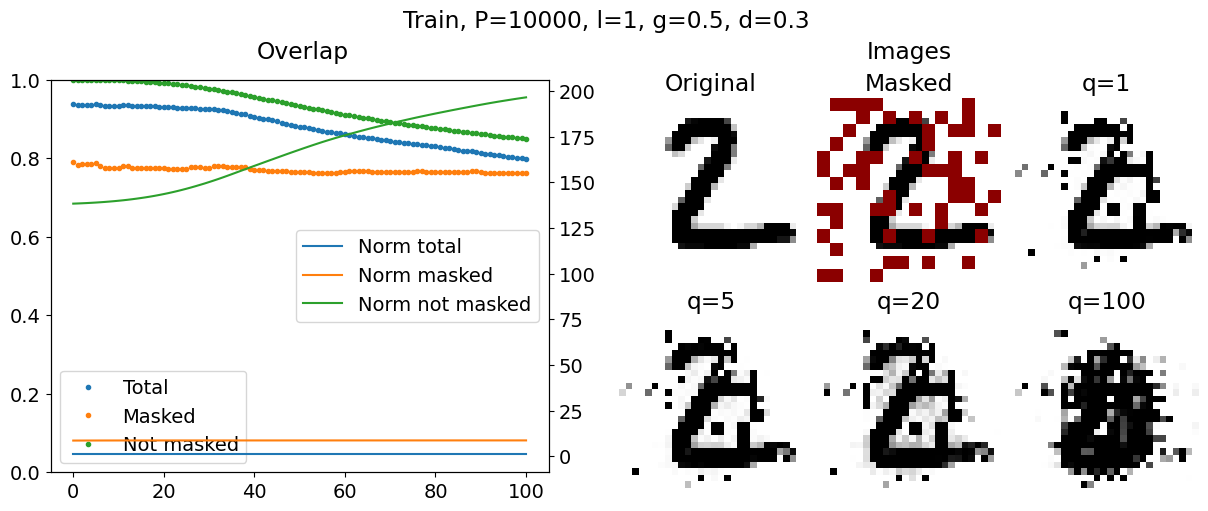

In [21]:
batch_element = 1
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

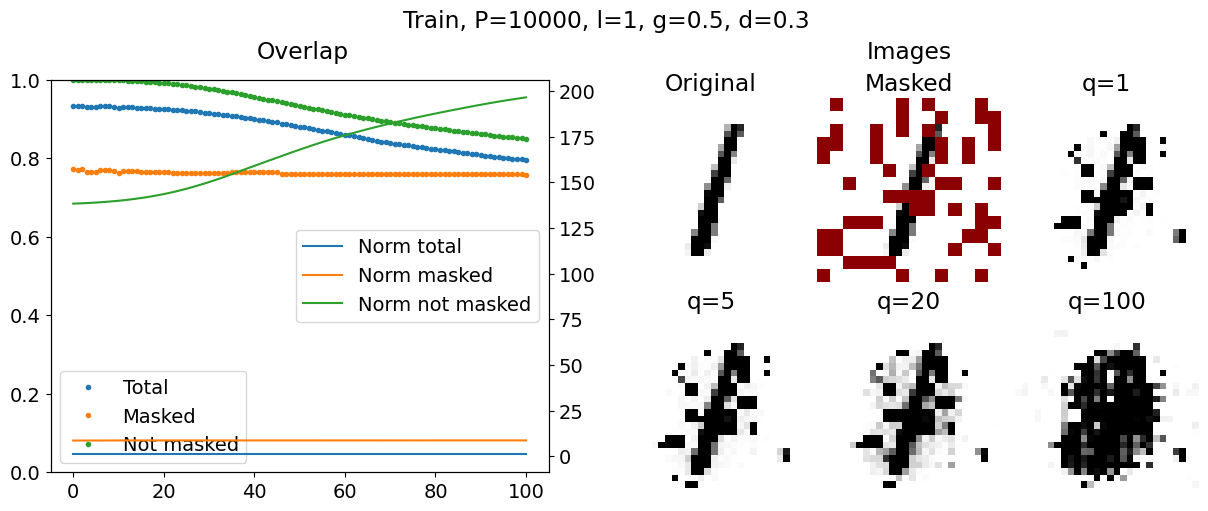

In [22]:
batch_element = 2
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

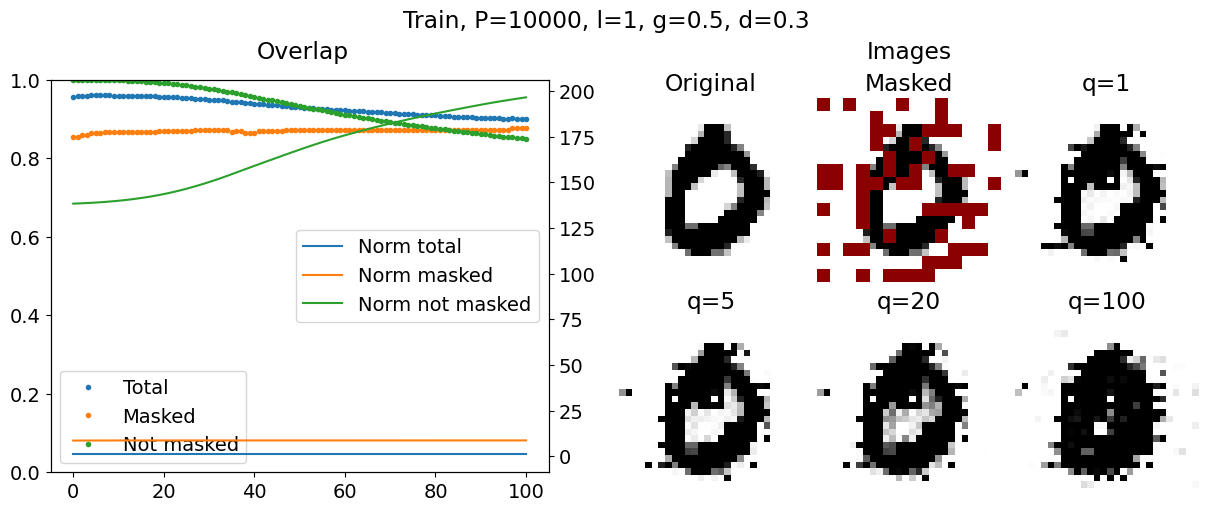

In [23]:
batch_element = 3
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)

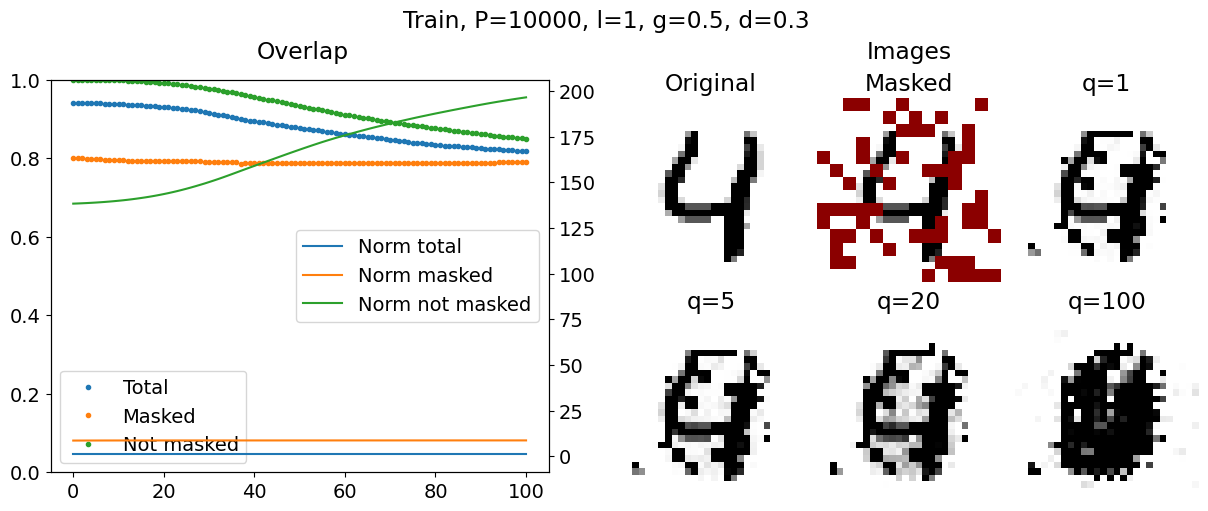

In [24]:
batch_element = 4
title = "Train, P={}, l={}, g={}".format(P, l, g)
print_q_repeating(tensor_images, overlap_curves, list_indexes, q_instants, batch_element, dist, title=title)